In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import pickle
import io

seed = 42
tf.random.set_seed(seed)

In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "powerconsumption.csv"

# Load the latest version
data_set = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "fedesoriano/electric-power-consumption",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", data_set.head())

/tmp/ipython-input-2-1980633077.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  data_set = kagglehub.load_dataset(


100%|██████████| 1.36M/1.36M [00:00<00:00, 113MB/s]

Extracting zip of powerconsumption.csv...
First 5 records:         Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0  1/1/2017 0:00        6.559      73.8      0.083                0.051   
1  1/1/2017 0:10        6.414      74.5      0.083                0.070   
2  1/1/2017 0:20        6.313      74.5      0.080                0.062   
3  1/1/2017 0:30        6.121      75.0      0.083                0.091   
4  1/1/2017 0:40        5.921      75.7      0.081                0.048   

   DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0         0.119             34055.69620             16128.87538   
1         0.085             29814.68354             19375.07599   
2         0.100             29128.10127             19006.68693   
3         0.096             28228.86076             18361.09422   
4         0.085             27335.69620             17872.34043   

   PowerConsumption_Zone3  
0             20240.96386  
1             20131.08434  
2  

In [3]:
data_set['Datetime'] = pd.to_datetime(data_set['Datetime'], infer_datetime_format=True)

/tmp/ipython-input-3-3500836945.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data_set['Datetime'] = pd.to_datetime(data_set['Datetime'], infer_datetime_format=True)


In [4]:
data_set['Day'] = data_set['Datetime'].dt.day
data_set['Month'] = data_set['Datetime'].dt.month
data_set['Year'] = data_set['Datetime'].dt.year

In [5]:
features = data_set.columns.to_list()
targets = [
    'PowerConsumption_Zone1',
    'PowerConsumption_Zone2',
    'PowerConsumption_Zone3'
    ]

for i in targets:
  features.remove(i)
features.remove('Datetime')

targets = ['PowerConsumption_Zone1']

In [6]:
X = data_set[features]
y = data_set[targets]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
scaler = StandardScaler()

In [11]:
X_train_transformed = scaler.fit_transform(X_train)

In [12]:
X_test_transformed = scaler.transform(X_test)

In [17]:
model = Sequential()

model.add(Dense(units=128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='linear'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.compile(optimizer='Adam', loss='mse', metrics=[RootMeanSquaredError()])
history = model.fit(X_train_transformed, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 32066166.0000 - root_mean_squared_error: 5662.4893 - val_loss: 31841756.0000 - val_root_mean_squared_error: 5642.8501
Epoch 2/100
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 31981344.0000 - root_mean_squared_error: 5655.0112 - val_loss: 31779676.0000 - val_root_mean_squared_error: 5637.3467
Epoch 3/100
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 31919846.0000 - root_mean_squared_error: 5649.5708 - val_loss: 31717956.0000 - val_root_mean_squared_error: 5631.8696
Epoch 4/100
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 31854518.0000 - root_mean_squared_error: 5643.7881 - val_loss: 31651914.0000 - val_root_mean_squared_error: 5626.0034
Epoch 5/100
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 31783154.0000 - root_mean_squared_error: 5637.4639 - val_loss: 31581936.0000 - val_root_mean_squared_error: 5619.7808
Epoch 6/100
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 31709148.0000 - root_mean_square

In [31]:
y_pred = model.predict(X_test_transformed)
r2_score(y_test, y_pred)

328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.46408480405807495

In [28]:
from sklearn.metrics import r2_score

In [24]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

<Axes: >

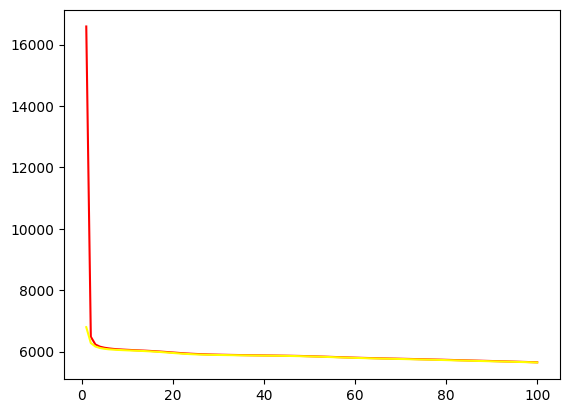

In [25]:
sns.lineplot(x=range(1, 101), y=history.history['root_mean_squared_error'], color='red')
sns.lineplot(x=range(1, 101), y=history.history['val_root_mean_squared_error'], color='yellow')

<Axes: >

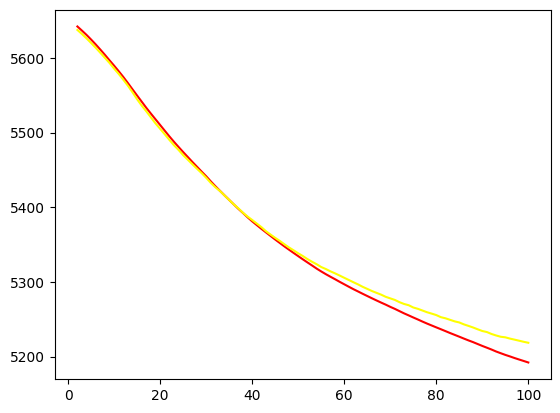

In [33]:
sns.lineplot(x=range(2, 101), y=history.history['root_mean_squared_error'][1:], color='red')
sns.lineplot(x=range(2, 101), y=history.history['val_root_mean_squared_error'][1:], color='yellow')

In [34]:
model_2 = Sequential()


model_2.add(Dense(units=32, input_dim=X_train.shape[1], activation='relu'))
model_2.add(Dense(units=64, activation='relu'))
model_2.add(Dense(units=128, activation='relu'))
model_2.add(Dense(units=256, activation='relu'))
model_2.add(Dense(units=1, activation='relu'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                loss='mse',
                metrics=[RootMeanSquaredError()])

history_new = model_2.fit(x=X_train_transformed,
            y=y_train,
            epochs=200,
            validation_split=0.2)

Epoch 1/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 193177056.0000 - root_mean_squared_error: 12774.4512 - val_loss: 36460648.0000 - val_root_mean_squared_error: 6038.2651
Epoch 2/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 37469592.0000 - root_mean_squared_error: 6121.0601 - val_loss: 35579032.0000 - val_root_mean_squared_error: 5964.8164
Epoch 3/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 36904896.0000 - root_mean_squared_error: 6074.7983 - val_loss: 35319680.0000 - val_root_mean_squared_error: 5943.0361
Epoch 4/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 36707328.0000 - root_mean_squared_error: 6058.5005 - val_loss: 35126908.0000 - val_root_mean_squared_error: 5926.7959
Epoch 5/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 36564996.0000 - root_mean_squared_error: 6046.7378 - val_loss: 35031056.0000 - val_root_mean_squared_error: 5918.7041
Epoch 6/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 36472676.0000 - root_mean_squ

<Axes: >

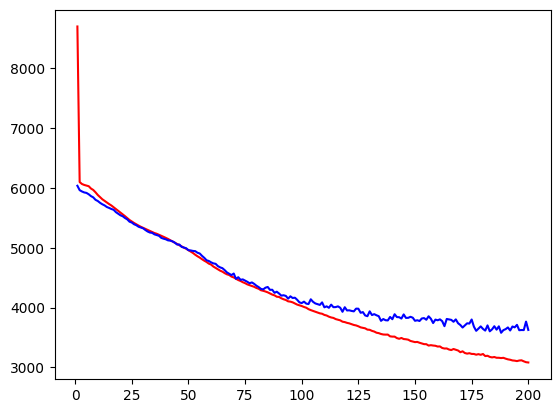

In [36]:
sns.lineplot(x=range(1, 201), y=history_new.history['root_mean_squared_error'], color='red')
sns.lineplot(x=range(1, 201), y=history_new.history['val_root_mean_squared_error'], color='blue')

In [37]:
y_pred_new = model_2.predict(X_test_transformed)
r2_score(y_test, y_pred_new)

328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


0.7473721504211426

In [38]:
y_test

,PowerConsumption_Zone1
27027,35548.70432
2068,16010.12658
44484,34240.00000
50773,31647.14829
8726,32292.76596
...,...
1807,33381.26582
13196,28992.20667
3791,23125.06329
4146,39505.82278


In [39]:
model_3 = Sequential()


model_3.add(Dense(units=32, input_dim=X_train.shape[1], activation='relu'))
model_3.add(Dense(units=64, activation='relu'))
model_3.add(Dense(units=128, activation='relu'))
model_3.add(Dense(units=256, activation='relu'))
model_3.add(Dense(units=1, activation='linear'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                loss='mse',
                metrics=[RootMeanSquaredError()])
history_m3 = model_3.fit(X_train_transformed,
            y_train,
            epochs=200,
            validation_split=0.2)

Epoch 1/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 37988452.0000 - root_mean_squared_error: 6163.1323 - val_loss: 35394304.0000 - val_root_mean_squared_error: 5949.3110
Epoch 2/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 36875744.0000 - root_mean_squared_error: 6072.4062 - val_loss: 34909252.0000 - val_root_mean_squared_error: 5908.4053
Epoch 3/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 36430360.0000 - root_mean_squared_error: 6035.6201 - val_loss: 34642852.0000 - val_root_mean_squared_error: 5885.8179
Epoch 4/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 36219600.0000 - root_mean_squared_error: 6018.1338 - val_loss: 34484044.0000 - val_root_mean_squared_error: 5872.3115
Epoch 5/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 35885536.0000 - root_mean_squared_error: 5990.2998 - val_loss: 34214568.0000 - val_root_mean_squared_error: 5849.3218
Epoch 6/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 35518628.0000 - root_mean_square

In [44]:
y_pred_m3 = model_3.predict(X_test_transformed)
r2_score(y_test, y_pred_m3)

328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.7571179866790771

<Axes: >

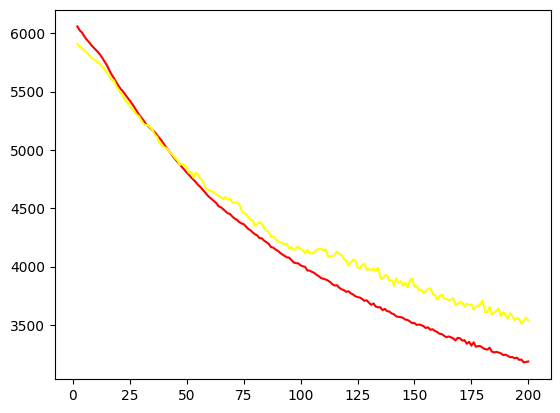

In [46]:
sns.lineplot(x=range(2, 201), y=history_m3.history['root_mean_squared_error'][1:], color='red')
sns.lineplot(x=range(2, 201), y=history_m3.history['val_root_mean_squared_error'][1:], color='yellow')

In [49]:
from tensorflow.keras.layers import Dropout

In [50]:
# model_3 + 512 neurons layer + dropout(0.5)

model_do = Sequential()


model_do.add(Dense(units=32, input_dim=X_train.shape[1], activation='relu'))
model_do.add(Dense(units=64, activation='relu'))
model_do.add(Dense(units=128, activation='relu'))
model_do.add(Dense(units=256, activation='relu'))
model_do.add(Dense(units=512, activation='relu'))
model_do.add(Dropout(0.5))
model_do.add(Dense(units=1, activation='linear'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
model_do.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                 loss='mse',
                 metrics=[RootMeanSquaredError()])
history_do = model_do.fit(x=X_train_transformed,
             y=y_train,
             epochs=100,
             validation_split=0.2)

Epoch 1/100
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 144981136.0000 - root_mean_squared_error: 11126.6318 - val_loss: 36739548.0000 - val_root_mean_squared_error: 6061.3159
Epoch 2/100
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 43544604.0000 - root_mean_squared_error: 6598.6582 - val_loss: 34319924.0000 - val_root_mean_squared_error: 5858.3208
Epoch 3/100
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 42462184.0000 - root_mean_squared_error: 6516.2300 - val_loss: 33939988.0000 - val_root_mean_squared_error: 5825.8037
Epoch 4/100
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 42150176.0000 - root_mean_squared_error: 6491.8525 - val_loss: 38060632.0000 - val_root_mean_squared_error: 6169.3301
Epoch 5/100
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 40658848.0000 - root_mean_squared_error: 6375.9116 - val_loss: 32411392.0000 - val_root_mean_squared_error: 5693.1006
Epoch 6/100
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 40211216.0000 - root_mean_sq

In [53]:
y_pred_do = model_do.predict(X_test_transformed)
r2_score(y_test, y_pred_do)

328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


0.7218536138534546

<Axes: >

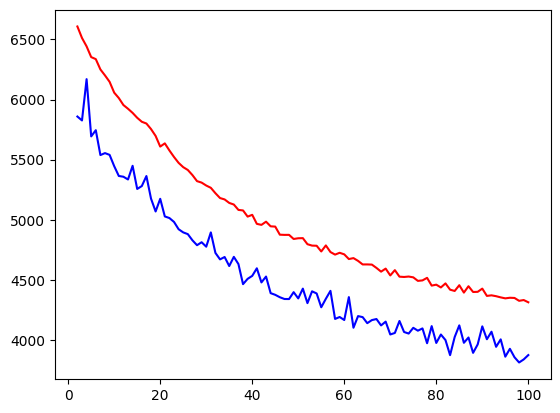

In [54]:
sns.lineplot(x=range(2, 101), y=history_do.history['root_mean_squared_error'][1:], color='red')
sns.lineplot(x=range(2, 101), y=history_do.history['val_root_mean_squared_error'][1:], color='blue')

In [55]:
# model_3 + dropout(0.3)

model_do_2 = Sequential()


model_do_2.add(Dense(units=32, input_dim=X_train.shape[1], activation='relu'))
model_do_2.add(Dense(units=64, activation='relu'))
model_do_2.add(Dense(units=128, activation='relu'))
model_do_2.add(Dense(units=256, activation='relu'))
model_do_2.add(Dropout(0.3))
model_do_2.add(Dense(units=1, activation='linear'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
model_do_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                   loss='mse',
                   metrics=[RootMeanSquaredError()])
history_do_m2 = model_do_2.fit(x=X_train_transformed,
                               y=y_train,
                               epochs=200,
                               validation_split=0.2)

Epoch 1/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 197456208.0000 - root_mean_squared_error: 12960.9580 - val_loss: 37664468.0000 - val_root_mean_squared_error: 6137.1382
Epoch 2/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 42988972.0000 - root_mean_squared_error: 6556.3857 - val_loss: 35718256.0000 - val_root_mean_squared_error: 5976.4751
Epoch 3/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 41883604.0000 - root_mean_squared_error: 6471.4771 - val_loss: 36021324.0000 - val_root_mean_squared_error: 6001.7769
Epoch 4/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 41689616.0000 - root_mean_squared_error: 6456.3579 - val_loss: 35300240.0000 - val_root_mean_squared_error: 5941.4004
Epoch 5/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 41357820.0000 - root_mean_squared_error: 6430.6899 - val_loss: 34791356.0000 - val_root_mean_squared_error: 5898.4199
Epoch 6/200
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 41315020.0000 - root_mean_squa

In [57]:
y_pred_do_m2 = model_do_2.predict(X_test_transformed)
r2_score(y_test, y_pred_do_m2)

328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


0.728606641292572

<Axes: >

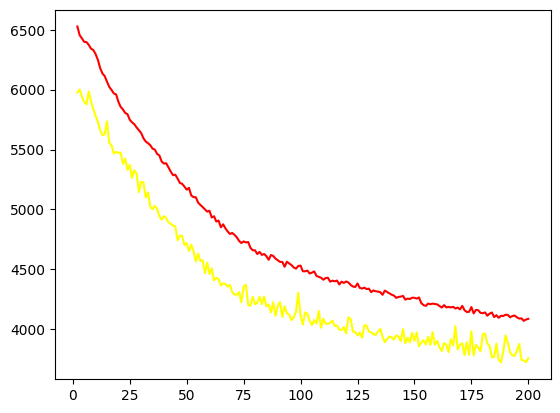

In [58]:
sns.lineplot(x=range(2, 201), y=history_do_m2.history['root_mean_squared_error'][1:], color='red')
sns.lineplot(x=range(2, 201), y=history_do_m2.history['val_root_mean_squared_error'][1:], color='yellow')

<Axes: >

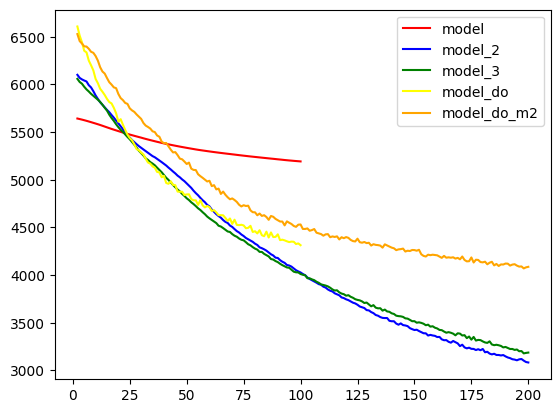

In [60]:
sns.lineplot(x=range(2, 101), y=history.history['root_mean_squared_error'][1:], color='red', label="model")
sns.lineplot(x=range(2, 201), y=history_new.history['root_mean_squared_error'][1:], color='blue', label="model_2")
sns.lineplot(x=range(2, 201), y=history_m3.history['root_mean_squared_error'][1:], color='green', label="model_3")
sns.lineplot(x=range(2, 101), y=history_do.history['root_mean_squared_error'][1:], color='yellow', label="model_do")
sns.lineplot(x=range(2, 201), y=history_do_m2.history['root_mean_squared_error'][1:], color='orange', label="model_do_m2")

In [63]:
from sklearn.metrics import root_mean_squared_error

In [61]:
mean_val = np.mean(y_test)

In [64]:
comparisions = {
    "model": {
        "Relative RMSE": root_mean_squared_error(y_test, y_pred)/mean_val,
        "R2 score": r2_score(y_test, y_pred)
    },

    "model_2": {
        "Relative RMSE": root_mean_squared_error(y_test, y_pred_new)/mean_val,
        "R2 score": r2_score(y_test, y_pred_new)
    },

    "model_3": {
        "Relative RMSE": root_mean_squared_error(y_test, y_pred_m3)/mean_val,
        "R2 score": r2_score(y_test, y_pred_m3),
    },

    "model_do": {
        "Relative RMSE": root_mean_squared_error(y_test, y_pred_do)/mean_val,
        "R2 score": r2_score(y_test, y_pred_do)
    },

    "model_do_2": {
        "Relative RMSE": root_mean_squared_error(y_test, y_pred_do_m2)/mean_val,
        "R2 score": r2_score(y_test, y_pred_do_m2)
    }
}

In [65]:
pd.DataFrame(comparisions)

,model,model_2,model_3,model_do,model_do_2
Relative RMSE,0.161215,0.110687,0.108531,0.116143,0.114724
R2 score,0.464085,0.747372,0.757118,0.721854,0.728607


In [68]:
with open('best model.pkl', 'wb') as f:
  pickle.dump(model_3, f)

In [69]:
with open('model 1.pkl', 'wb') as f:
  pickle.dump(model, f)
  f.close()

with open('model 2.pkl', 'wb') as f:
  pickle.dump(model_2, f)
  f.close()

with open('model DO.pkl', 'wb') as f:
  pickle.dump(model_do, f)
  f.close()

with open('model DO 2.pkl', 'wb') as f:
  pickle.dump(model_do_2, f)
  f.close()

